# Medical Image Classification with PyTorch

In [3]:
# ! pip install torchvision

# from torch.cuda import is_available, get_device_name

# if is_available():
#     print(f"The environment has a compatible GPU ({get_device_name()}) available.")
# else:
#     print(f"The environment does NOT have a compatible GPU model available.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.0 MB/s eta 0:00:0000:0100:01


In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [2]:
# Defining Helper Functions
# This function will allow us to easily plot tensor data 
from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

# About DataSet
Dataset
PCam Images
The PatchCamelyon dataset is a challenging image classification benchmark that consists of color images (96 x 96px) from histopathologic scans of lymph node sections. 
Each image is labeled with a binary indicating metastatic tissue. PCam is a suitable benchmark for machine learning models as it is bigger than CIFAR10 and smaller than ImageNet, 
and can be trained on a single GPU, making it accessible and affordable for researchers and practitioners.



In [3]:
# loading images from zip file (it takes few minutes)

import zipfile
from tqdm import tqdm

with zipfile.ZipFile("data_sample.zip", "r") as zip_ref:
    # get the total number of files in the zip file
    total_files = len(zip_ref.infolist())

    # iterate over the files in the zip file and extract them
    for file in tqdm(zip_ref.infolist(), total=total_files):
        zip_ref.extract(file, "data_sample")

# removing one unwanted file in the data_sample folder
os.remove("data_sample/data_sample/.DS_Store")

100%|█████████████████████████████████████| 8021/8021 [00:01<00:00, 5653.09it/s]


In [4]:
## Load the label of data
labels_df = pd.read_csv("labels.csv")
labels_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

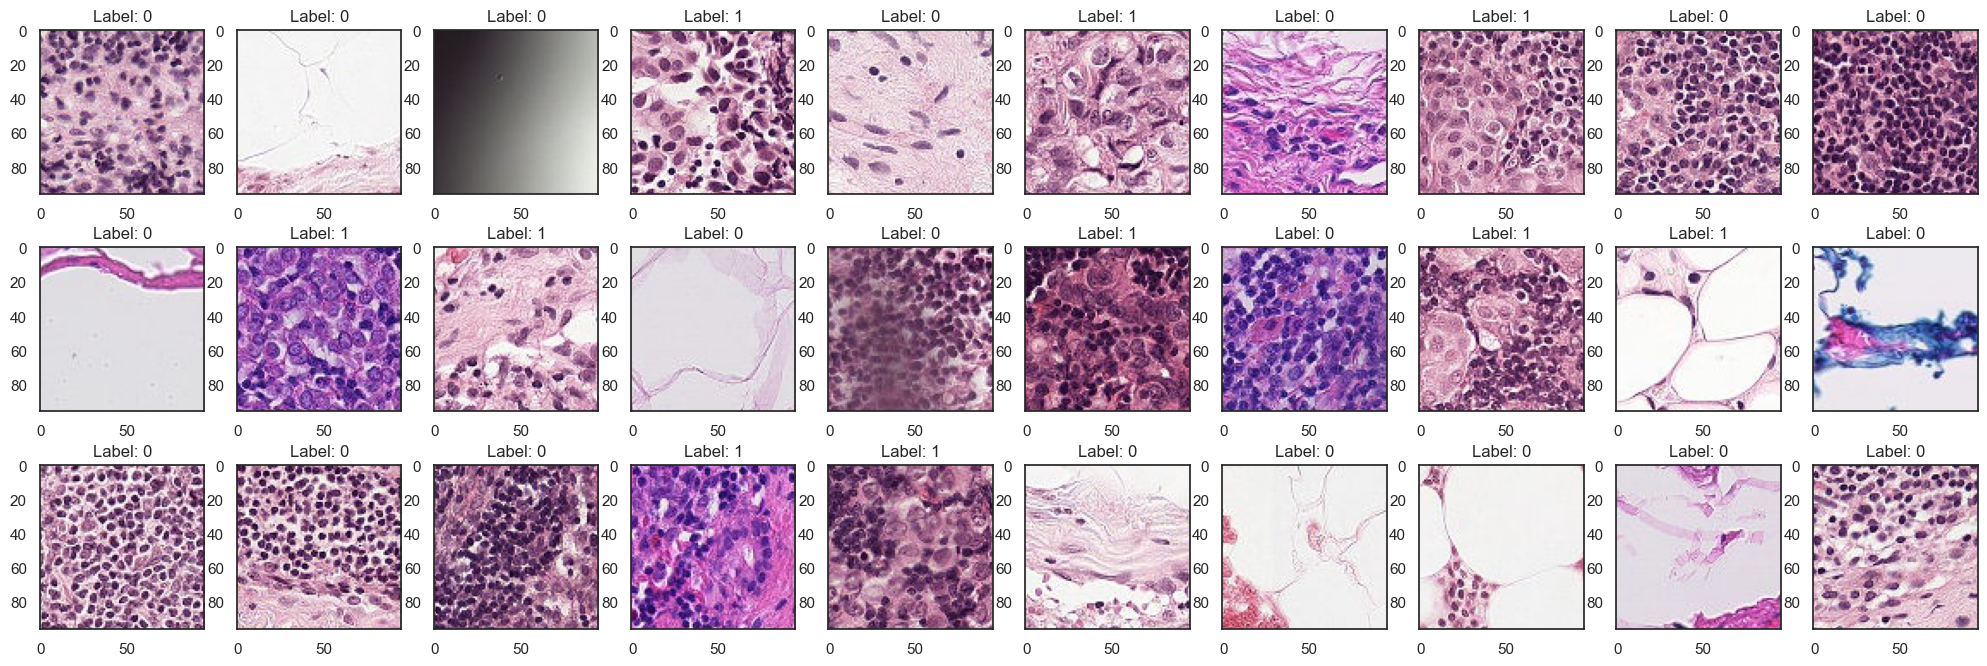

In [5]:
# Visualize some sample data

# create a figure with a size of 25 by 8 inches
fig = plt.figure(figsize=(25, 8))

# set the path to the training data folder
path2data = "data_sample/data_sample"

# get a list of all image files in the training data folder
train_imgs = os.listdir(path2data)

# loop over a randomly chosen subset of 30 images
for idx, img in enumerate(np.random.choice(train_imgs, 30)):
    
    # add a subplot to the figure
    # specify that there will be 3 rows and 10 columns of subplots
    ax = fig.add_subplot(3, 30//3, idx+1)
    
    # open the current image file
    im = Image.open(path2data + "/" + img)
    
    # display the image in the current subplot
    plt.imshow(im)
    
    # extract the label for the current image from a DataFrame
    # that has a column of image ids and their corresponding labels
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]
    
    # set the title of the current subplot to the image label
    ax.set_title(f'Label: {lab}')

# Data Preperation

create a cance_dataste class for loading images and their corresponding labels 
for a binary classification task using PyTorch

The class cancer_dataset inherits from the Dataset class provided by PyTorch and 
overrides the __init__, __len__, and __getitem__ methods.

In the __init__ method, the constructor takes in the directory path to the data, 
the desired image transformations to be applied, and the data type ("data_sample" by default). 
The method initializes a list of filenames of images present in the directory, obtains the full path to the images, 
and reads the labels from the 'labels.csv' file in the same directory. 
The image filenames without their extension (.png) are used to obtain their corresponding labels from the dataframe. 
The self.labels attribute is then populated with the labels for each image.

In the __len__ method, the number of images in the dataset is returned by taking the length of the full_filenames attribute.

In the `__getitem__` method, given an index `idx`, the method opens the image at that index using the 
`Image.open` method from the Python Imaging Library (PIL), applies the image transformation using the `self.transform` attribute, 
and returns a tuple containing the transformed image and its corresponding label from the `self.labels` attribute.

This class can be used to create a PyTorch `DataLoader` to load `batches` of images during training or inference.
    

In [6]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, dataset_type=None):
        # Get the path to the directory containing the images
        path2data = os.path.join(data_dir, "data_sample/data_sample")
        
        # Get a list of the filenames of the images in the directory
        filenames = os.listdir(path2data)

        # Get the full path to each image
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # Load the labels from a CSV file
        path2labels = os.path.join(data_dir, "labels.csv")
        labels_df = pd.read_csv(path2labels)

        # Set the "id" column as the index for the labels dataframe
        labels_df.set_index("id", inplace=True)

        # Obtain the labels for the dataset
        if dataset_type=="train":
            # Only use a subset of the images for training
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][0:3608]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][0:2608]
            print("training dataset")
            
        elif dataset_type=="val":
            # Only use a subset of the images for validation
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3508:3648]
            print("validation dataset")
            
        elif dataset_type=="test":
            # Only use a subset of the images for testing
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("testing dataset")
            
        else:
            # Use all the images for the dataset
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        # Save the data transformation to be applied to each image
        self.transform = transform

    def __len__(self):
        # Return the size of the dataset (i.e., the number of images)
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # Open the image file and apply the data transformation
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        
        # Return the transformed image along with its label
        return img, self.labels[idx]

Transform the Dataset

Now you might be thinking, won't the model only be trained to recognize those exact images with this dataset?

This is where image preprocessing comes in. We want to train the model with more data. One way to do this is to create copies of the image and transform those copies. This process helps the model recognize an object rather than only the picture itself. For example, we can vertically flip an image. The object in the image does not change. If we rotate that image by 5 degrees, the object in the image does not change either.

To do this with our dataset, we'll create a transformation process called "composed". This will create copies of the images that are resized, horizontally flipped and rotated. We'll also convert the images to a tensor and normalize its image channels.

We will create transformers to convert PIL image to PyTorch tensors

In [7]:
from torchvision import transforms

# data transformation 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed_train = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

# this transformation is for valiadationa and test sets
composed= transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

Here, we get a list of files in a specified directory and storing their file names as a list in Python.

In [8]:
import os 
from os import listdir
from os.path import isfile, join 

# Define path to directory
mypath = "/Users/danishkarur/opt/Python Scripts/Learnings_CognitiveClasses/MetaStaticCancer" #"opt/Python Scripts/Learnings_CognitiveClasses/MetaStaticCancer"

# Get list of only file names in directory
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
# Iterate through each item in list of directory contents returned by listdir function
# Check if item is a file using the isfile function
# If item is a file, add it to the onlyfiles list using the join function to create the full path to the file

In [9]:
# Get Path of this project

# import pathlib
# pathlib.Path("MetaStaticCancer").parent.resolve()

In [10]:
labels_df

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

With the handy class we created earlier, we can now create a dataset_full object, an instance of class Cancer_dataset.

In [11]:
# Let's load the dataset and look at a sample
data_dir = "./"
dataset_full = cancer_dataset(data_dir , transform=composed)

In [12]:
img, label = dataset_full [19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 224, 224]) tensor(-2.0182) tensor(2.6400)


In [13]:
# Split the Dataset
# creating the object of cancer_dataset for train, test, and validation
training_set=cancer_dataset(data_dir , transform=composed_train,dataset_type="train")
 
validation_set=cancer_dataset(data_dir , transform=composed,dataset_type="val")
test_set=cancer_dataset(data_dir , transform=composed,dataset_type="test")
print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')


training dataset
validation dataset
testing dataset
training dataset length: 2608
validation dataset length: 140
test dataset length: 360


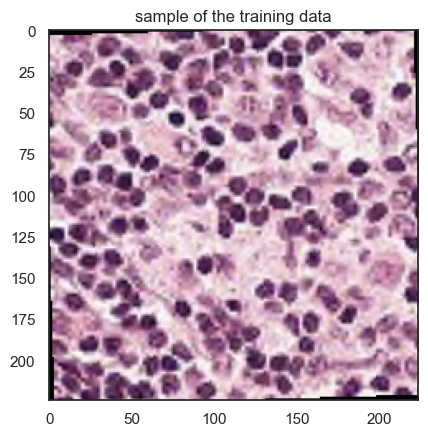

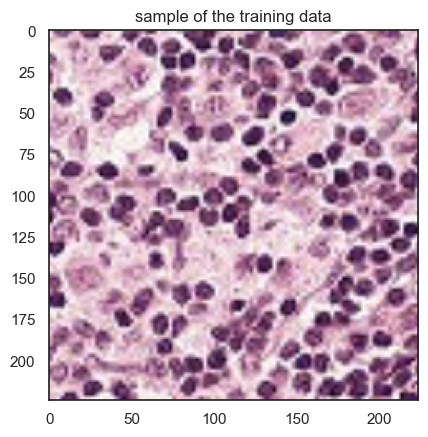

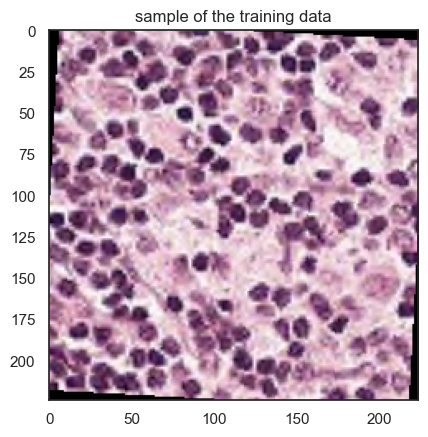

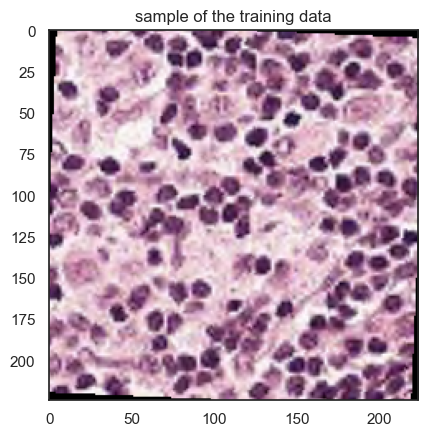

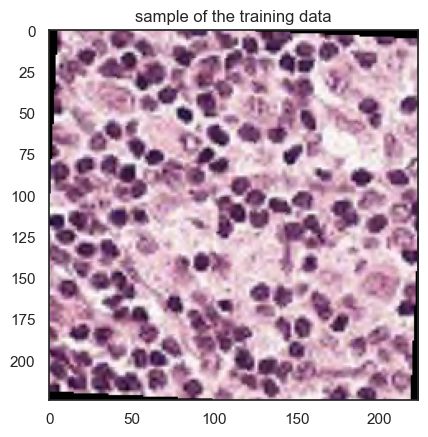

In [14]:
# We can plot a sample of the training data, we see each time it changes slightly randomly

for i in range(5):
    plt.title("sample of the training data")
    imshow(training_set[2][0])

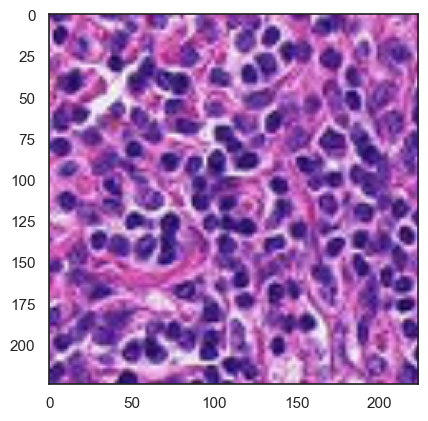

In [15]:
# Similarly the test and validation images
imshow(test_set[0][0])

Pytorch DataLoader

PyTorch DataLoader is a utility that helps to load and iterate over a dataset during the training and evaluation of deep learning models. It provides an iterable interface to the dataset and performs multi-process loading of data, which improves the data loading speed, especially when the data is stored on disk or in a remote location.

A DataLoader can shuffle the data before each epoch, apply transformations to the data, and combine multiple batches of data into a single batch. The batch size and the number of worker processes that load the data can be configured, which can help to optimize the memory usage and loading speed of the data. The PyTorch DataLoader is a flexible and efficient way to handle large datasets, and it is commonly used in deep learning projects.

In [16]:
# Load data
train_loader = torch.utils.data.DataLoader(training_set, batch_size=10, shuffle=True, num_workers=2)

# we dont use validation in this project, but it is recommended to use for your future traning procedure
#val_loader = torch.utils.data.DataLoader(validation_set, batch_size=10, shuffle=False, num_workers=2)


test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, num_workers=2)

# Define classes
num_classes = 2
print("done")

done


Set Your Hyperparameters
Hyperparameters are important settings that can greatly affect the performance of a machine learning model. Common hyperparameters include batch size and learning rate, which can be adjusted to find the most optimal values for the model. Tuning these hyperparameters is typically a time-consuming and iterative process, but in this case, we've already taken care of that for you!

For this particular model, we have set the batch size, learning rate, and number of epochs to predetermined values. The batch size refers to the number of sample images that are used in one iteration of training the model, while the learning rate determines how much the model will change between iterations. The number of epochs indicates the number of times that the model will be trained on the entire dataset.Hyperparameters are important settings that can greatly affect the performance of a machine learning model. Common hyperparameters include batch size and learning rate, which can be adjusted to find the most optimal values for the model. Tuning these hyperparameters is typically a time-consuming and iterative process, but in this case, we've already taken care of that for you!

For this particular model, we have set the batch size, learning rate, and number of epochs to predetermined values. The batch size refers to the number of sample images that are used in one iteration of training the model, while the learning rate determines how much the model will change between iterations. The number of epochs indicates the number of times that the model will be trained on the entire dataset.

In [17]:
# Batch size: train set  
batch_size = 30

# Learning rate  
lr = 3e-4

# Number epochs 
n_epochs = 5

Load Your Model

Let's begin to define our model by loading it. 
For this lab, we'll be using the pre-trained model, 
ResNet34, a state-of-the-art image classification network by Microsoft. 
To load this model, we'll be using the following code, 
with the parameter pretrained set to True.

In [18]:
from torchvision import models

model = models.resnet34(pretrained = True)

The original network was designed for classifying the image to 
1,000 different classes. In our case, we only have 2 classes. 
For that reason, we'll replace the final layer to reduce the number of neurons from 1,000 to 2. 
Consequently, we'll need to retrain the final layer. To achieve this, 
we'll freeze the existing model parameters and replace the final layer.

Search for the Optimal Model

With your toolkit assembled, tools prepared and model loaded, it's now time to put them to use by embarking on a journey to search for the optimal parameters. This will result in a model that will ideally have a high accuracy, meaning that it will more often than not detect when an image is a cancer or not a cancer correctly.

To search for the optimal parameters, we must first define a metric to measure what is optimal. In machine learning, this is done by defining a loss function. A more optimized model will have a lower loss. Since this neural network is designed to perform classification tasks, cross entropy loss (a loss function) becomes the natural choice to construct the model.

In [19]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [20]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = lr)

By freezing the parameters, we ensure that the pre-trained weights are not updated during the training process. Instead, we only update the parameters of the newly added layers or the layers that are not frozen. This allows us to reuse the knowledge that the pre-trained model has learned while training the new layers on a new task.

Now that we have everything we need to train the model, we can set up our training framework:

In [21]:
num_classes = 2
# Load pretrained model
model = models.resnet34(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Modify last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

Train and Test the Model¶
Next, we train the model by looping through the 
training dataset and train the model 
for one epoch (one pass through the dataset).
We select one epoch due to limitation in computational power

During each epoch, it calculates the loss between the 
model's predicted output and the true output labels, 
computes the gradients of the loss with respect to the model parameters, 
updates the parameters using the optimizer, and tracks the average loss over time. It also prints the average 
loss every 100 iterations of the training loop to provide some indication of the model's training progress. Overall, 
the code implements the basic training procedure for a PyTorch machine learning model.

In [ ]:
# Train model

for epoch in range(1): # Loop over a single epoch
    running_loss = 0.0 # Initialize variable to track loss

    # Loop over the training data using a PyTorch DataLoader
    for i, data in enumerate(tqdm(train_loader)):
        # Extract inputs and labels from the data
        inputs, labels = data

        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss between the model outputs and labels
        loss = criterion(outputs, labels)

        # Backpropagate the loss and compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Update the running loss with the current batch loss
        running_loss += loss.item()
   

        # Print the average loss every 100 iterations
        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 # Reset running loss for the next 100 iterations


In [ ]:
# Test the model
correct = 0 # Initialize variable to keep track of correctly classified images
total = 0 # Initialize variable to keep track of total images

# Use the model for inference, and disable gradient tracking
with torch.no_grad():
    for data in tqdm(test_loader): # Loop over the test data using a PyTorch DataLoader
        images, labels = data # Extract images and labels from the data

        # Forward pass through the model to obtain predictions
        outputs = model(images)

        # Find the predicted classes from the model's outputs
        # by taking the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count of images seen
        total += labels.size(0)

        # Update the count of correctly classified images
        correct += (predicted == labels).sum().item()

# Compute and print the model's accuracy on the test set
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
